## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

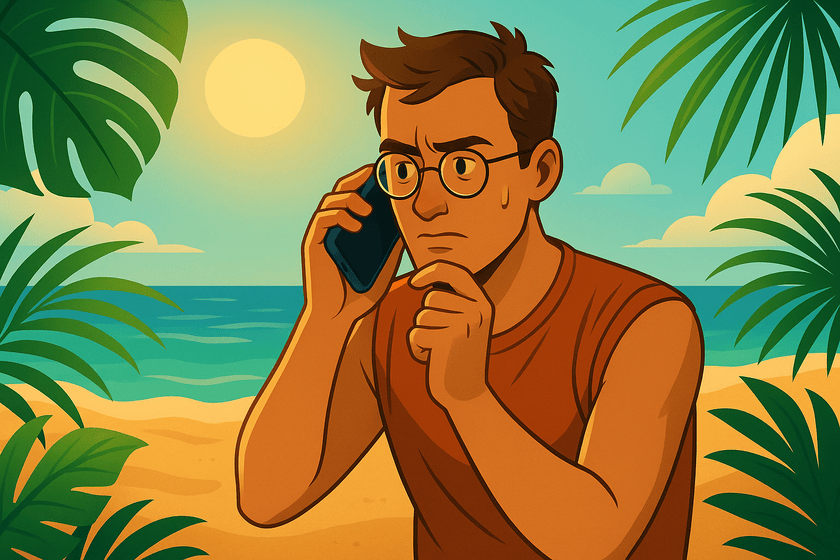

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

In [79]:
# ładowanie zbioru danych
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import random
from torchvision import datasets, transforms
import itertools
import time
import os
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42 # super śmieszne

def set_seed(seed):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [93]:
import kagglehub
import os
import shutil

path = kagglehub.dataset_download("pintowar/numerical-images")

print("destination:", path)

target_path = os.path.join("data")

os.makedirs(target_path, exist_ok=True)

for file_name in os.listdir(path):
    src_file = os.path.join(path, file_name)
    dst_file = os.path.join(target_path, file_name)

    if os.path.isdir(src_file):
        shutil.copytree(src_file, dst_file, dirs_exist_ok=True)
    else:
        shutil.copy2(src_file, dst_file)

print("moved to:", target_path)


destination: C:\Users\jakub\.cache\kagglehub\datasets\pintowar\numerical-images\versions\1
moved to: data


In [94]:
from torchvision import datasets, transforms


ROOT = './data/numbers/mnist_png/Hnd'
assert os.path.isdir(ROOT), f"Nie ma katalogu: {ROOT}. Sprawdź ścieżkę."

MEAN, STD = 0.47, 0.29
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

#mam własny zbiór jak coś
ds = datasets.ImageFolder(root=ROOT, transform=transform)
print("Liczba klas:", len(ds.classes))
print("Mapowanie klas:", ds.class_to_idx)

Liczba klas: 10
Mapowanie klas: {'Sample0': 0, 'Sample1': 1, 'Sample2': 2, 'Sample3': 3, 'Sample4': 4, 'Sample5': 5, 'Sample6': 6, 'Sample7': 7, 'Sample8': 8, 'Sample9': 9}


In [96]:
labels = np.array([y for img, y in ds])
idxs_by_class = [np.where(labels == c)[0] for c in range(len(ds.classes))]

train_idx, val_idx, test_idx = [], [], []
number_generator = np.random.default_rng(42) # znowu 42 giga śmieszne

#dzielę zbiór na podzbiory: treningowy, testowy i walidacyjny w proporcjach 70:15:15
for idxs in idxs_by_class:
    number_generator.shuffle(idxs)
    n = len(idxs)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    train_idx.extend(idxs[:n_train])
    val_idx.extend(idxs[n_train:n_train+n_val])
    test_idx.extend(idxs[n_train+n_val:])

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

In [97]:
BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

### sprawdźmy, ile jest elementów w poszczególnych klasach

In [98]:
def count_by_class(subset, name):
    ys = [labels[i] for i in subset.indices]
    counts = np.bincount(ys, minlength=len(ds.classes))
    print(f"{name} counts:", counts)

count_by_class(train_ds, "TRAIN")
count_by_class(val_ds,   "VAL")
count_by_class(test_ds,  "TEST")

TRAIN counts: [4146 4719 4170 4291 4089 3794 4142 4385 4095 4164]
VAL counts: [ 888 1011  893  919  876  813  887  939  877  892]
TEST counts: [ 889 1012  895  921  877  814  889  941  879  893]


### elegancko, wszystko działa :D balans klas jest zachowany, wszystkie klasy mają dokładnie tyle samo elementów

In [99]:
import os

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)  # musiałem spłaszczyć bo mi wywalało błąd nieprawidłowych wymiarów mnożenia
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim  = 28 * 28
hidden_dim = 256
output_dim = 10

model_to_save = SimpleNN(input_dim, hidden_dim, output_dim)
model_save_path = 'simple_cnn_no_mnist.pth'
torch.save(model_to_save.state_dict(), model_save_path)

### teraz zoptymalizuję to Adamem (kim jest Adam?). Jako kryterium wybrałem entropię krzyżową, bo mamy tu standardowy problem wieloklasowy:

In [100]:
EPOCHS = 8

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_save.parameters(), lr=1e-3)
model = model_to_save

def run_epoch(loader, train: bool):
  # jak epochy wpływają na wynik?
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/8 | train loss 0.3556 acc 0.8920 | val loss 0.2368 acc 0.9294
Ep 02/8 | train loss 0.1699 acc 0.9494 | val loss 0.1699 acc 0.9467
Ep 03/8 | train loss 0.1281 acc 0.9607 | val loss 0.1759 acc 0.9476
Ep 04/8 | train loss 0.1022 acc 0.9686 | val loss 0.1269 acc 0.9624
Ep 05/8 | train loss 0.0839 acc 0.9734 | val loss 0.1098 acc 0.9696
Ep 06/8 | train loss 0.0705 acc 0.9779 | val loss 0.1083 acc 0.9683
Ep 07/8 | train loss 0.0636 acc 0.9792 | val loss 0.1114 acc 0.9682
Ep 08/8 | train loss 0.0574 acc 0.9814 | val loss 0.1125 acc 0.9692
Czas treningu: 357.8s


## szybkie sanity check czy po normalizacji wszystkie zdjęcia nie są czarne

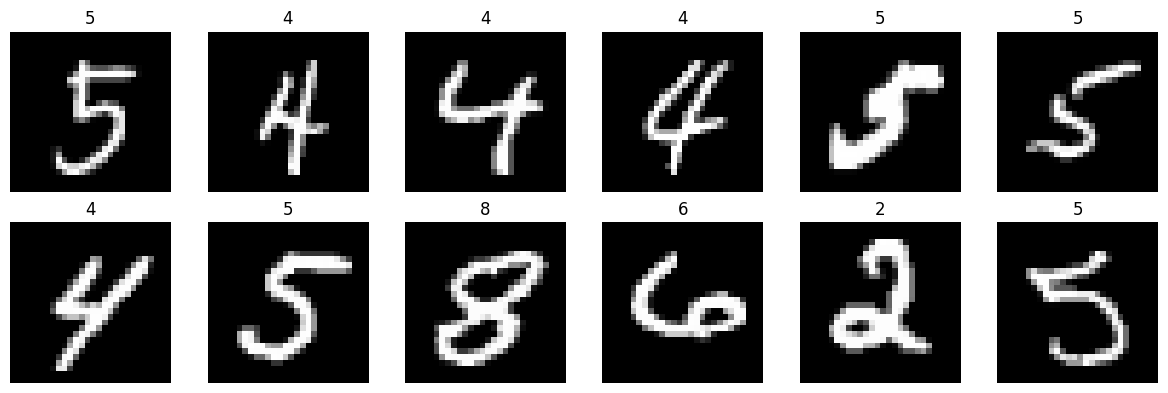

In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt

MEAN = 0.47
STD  = 0.29

def _to_tensor_param(p, x):
    t = torch.as_tensor(p, dtype=x.dtype, device=x.device)
    if t.ndim == 0:   # skalar
        t = t.view(1, 1, 1, 1)
    else:
        t = t.view(1, t.numel(), 1, 1)
    return t

def denorm(x, mean=MEAN, std=STD):
    mean_t = _to_tensor_param(mean, x)
    std_t  = _to_tensor_param(std,  x)
    return (x * std_t + mean_t).clamp(0, 1)

def denorm_show(loader, n=12):
    xb, yb = next(iter(loader))
    xb_vis = denorm(xb.clone())
    cols = min(6, n); rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(min(n, xb_vis.size(0))):
        plt.subplot(rows, cols, i+1)
        img = xb_vis[i]
        if img.shape[0] == 1:
            plt.imshow(img[0].numpy(), cmap="gray")
        else:
            plt.imshow(np.transpose(img.numpy(), (1,2,0)))
        plt.title(int(yb[i])); plt.axis("off")
    plt.tight_layout(); plt.show()

denorm_show(train_loader)

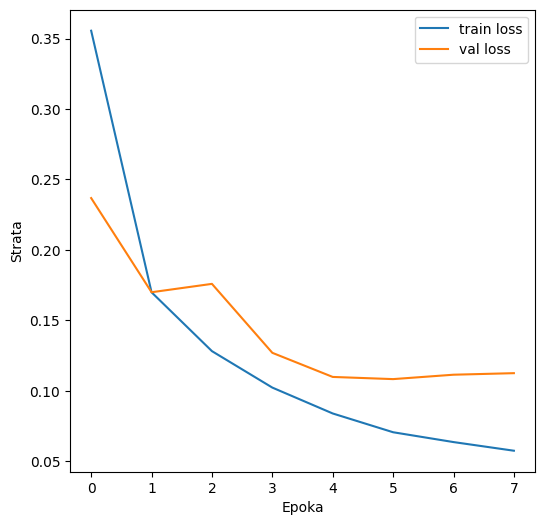

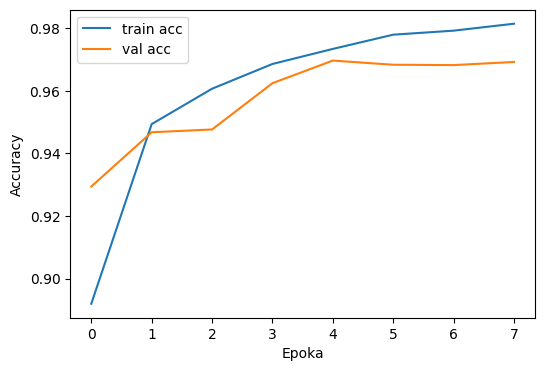

In [102]:
# ukradłem z notatnika, ale grzech by było nie skorzystać:

plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## pozostałe wizualizacje

#### Znormalizowana macierz pomyłek

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
test_f1_macro = f1_score(y_true, y_pred, average="macro")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
test_f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

              precision    recall  f1-score   support

           0     0.9840    0.9696    0.9768       889
           1     0.9853    0.9911    0.9882      1012
           2     0.9803    0.9430    0.9613       895
           3     0.9789    0.9555    0.9670       921
           4     0.9680    0.9669    0.9675       877
           5     0.9728    0.9681    0.9704       814
           6     0.9820    0.9831    0.9826       889
           7     0.9547    0.9405    0.9475       941
           8     0.9535    0.9568    0.9551       879
           9     0.8970    0.9754    0.9345       893

    accuracy                         0.9651      9010
   macro avg     0.9657    0.9650    0.9651      9010
weighted avg     0.9658    0.9651    0.9653      9010



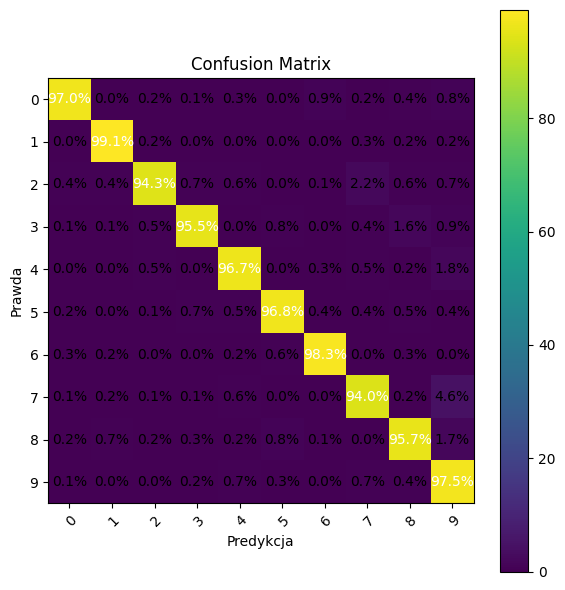

In [104]:
def plot_confusion_matrix(cm: any, class_names=None, title: str ="Confusion Matrix"): #wgl super że python ma teraz statyczne typowanie
    cm = cm.astype(np.float64)
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    cm_norm = cm / row_sums * 100.0

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm_norm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predykcja")
    ax.set_ylabel("Prawda")
    n_classes = cm.shape[0]
    ticks = np.arange(n_classes)
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    ax.set_xticks(ticks); ax.set_yticks(ticks)
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm_norm.max() / 2.0
    for i, j in itertools.product(range(n_classes), range(n_classes)):
        ax.text(j, i, f"{cm_norm[i, j]:.1f}%", ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, class_names=class_names)

#### Jakie są top pomyłki?

In [105]:
from collections import Counter

def print_top_confusions(y_true, y_pred, top_k=10):
    pairs = [(int(t), int(p)) for t, p in zip(y_true, y_pred) if t != p]
    counts = Counter(pairs).most_common(top_k)
    if not counts:
        print("Brak pomyłek – model trafił wszystko. Nice.")
        return
    print(f"Top {top_k} pomyłek (true → pred, liczność):")
    for (t, p), c in counts:
        print(f"{t} → {p}: {c}")

print_top_confusions(y_true, y_pred)

Top 10 pomyłek (true → pred, liczność):
7 → 9: 43
2 → 7: 20
4 → 9: 16
3 → 8: 15
8 → 9: 15
0 → 6: 8
3 → 9: 8
0 → 9: 7
3 → 5: 7
8 → 5: 7


#### Co model najczęściej mylił? Przykłady z galerii

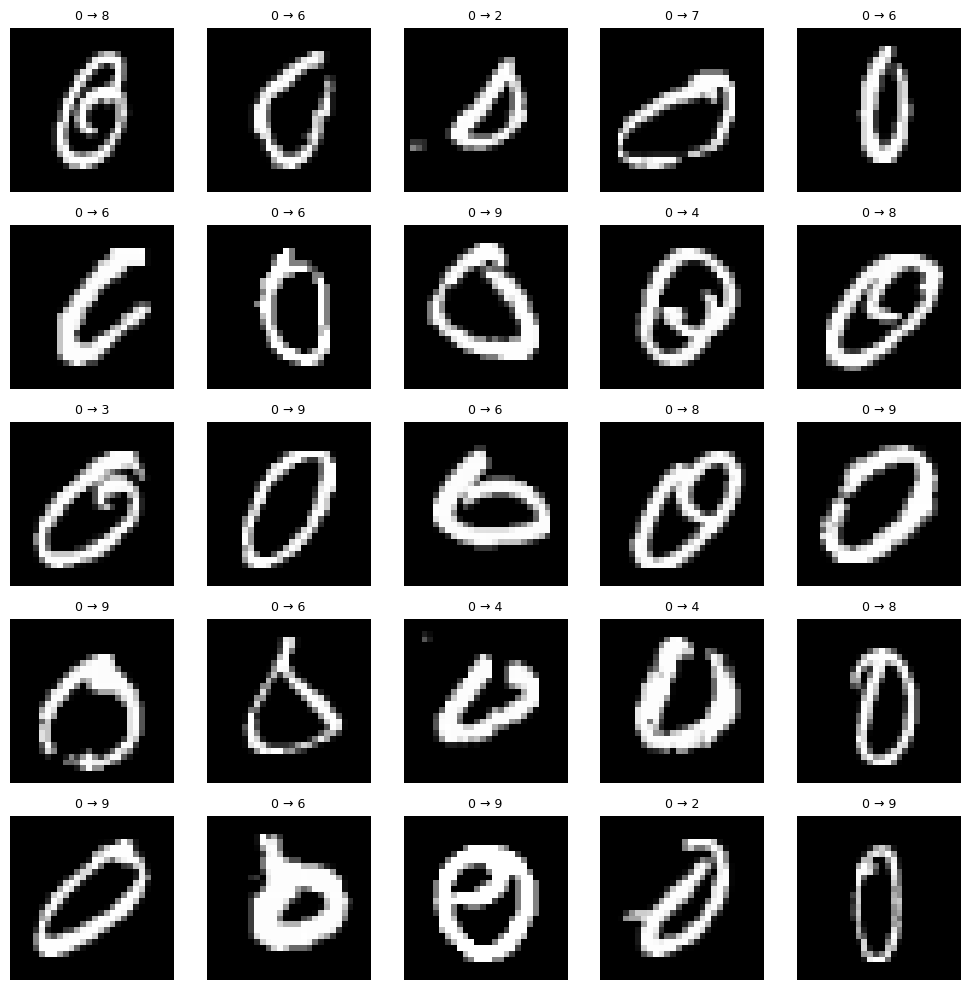

In [106]:
def show_misclassified_grid(model, loader, device, max_items=25, class_names=None):
    model.eval()
    wrong_imgs, wrong_true, wrong_pred = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu()
            yb_cpu = yb.cpu()
            wrong_mask = preds != yb_cpu
            if wrong_mask.any():
                sel = wrong_mask.nonzero(as_tuple=False).squeeze(1)
                for idx in sel:
                    img = xb[idx].detach().cpu()
                    wrong_imgs.append(img)
                    wrong_true.append(int(yb_cpu[idx].item()))
                    wrong_pred.append(int(preds[idx].item()))
                    if len(wrong_imgs) >= max_items:
                        break
            if len(wrong_imgs) >= max_items:
                break

    if len(wrong_imgs) == 0:
        print("Model okazał się nieomylny. Szok!")
        return

    n = len(wrong_imgs)
    cols = min(5, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, img in enumerate(wrong_imgs):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 3 and img.shape[0] == 1:
            plt.imshow(img.squeeze(0), cmap="gray")
        elif img.ndim == 3 and img.shape[0] == 3:
            plt.imshow(np.transpose(img.numpy(), (1,2,0)))
        else:
            plt.imshow(img.squeeze(), cmap="gray")
        t = wrong_true[i]; p = wrong_pred[i]
        t_name = class_names[t] if class_names and t < len(class_names) else str(t)
        p_name = class_names[p] if class_names and p < len(class_names) else str(p)
        plt.title(f"{t_name} → {p_name}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_misclassified_grid(model, test_loader, DEVICE, max_items=25, class_names=class_names)

#### część z tych liczb sam bym pomylił XD uważam, że generalnie jak na prostą sieć neuronową, wynik jest zadawalający. Widać, że model najczęściej myli zera i uznaje je za inne liczby. Teraz spróbujmy użyć CNNa

In [107]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [108]:
from torch.optim import Adam

EPOCHS = 12
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")


Ep 01/12 | train loss 0.2077 acc 0.9351 | val loss 0.0573 acc 0.9822
Ep 02/12 | train loss 0.0690 acc 0.9788 | val loss 0.0475 acc 0.9857
Ep 03/12 | train loss 0.0515 acc 0.9839 | val loss 0.0413 acc 0.9870
Ep 04/12 | train loss 0.0405 acc 0.9867 | val loss 0.0466 acc 0.9872
Ep 05/12 | train loss 0.0367 acc 0.9879 | val loss 0.0343 acc 0.9894
Ep 06/12 | train loss 0.0312 acc 0.9901 | val loss 0.0373 acc 0.9884
Ep 07/12 | train loss 0.0273 acc 0.9913 | val loss 0.0379 acc 0.9899
Ep 08/12 | train loss 0.0246 acc 0.9923 | val loss 0.0395 acc 0.9884
Ep 09/12 | train loss 0.0225 acc 0.9928 | val loss 0.0383 acc 0.9895
Ep 10/12 | train loss 0.0202 acc 0.9933 | val loss 0.0438 acc 0.9888
Ep 11/12 | train loss 0.0192 acc 0.9934 | val loss 0.0381 acc 0.9901
Ep 12/12 | train loss 0.0191 acc 0.9940 | val loss 0.0407 acc 0.9897
Czas treningu: 455.5s


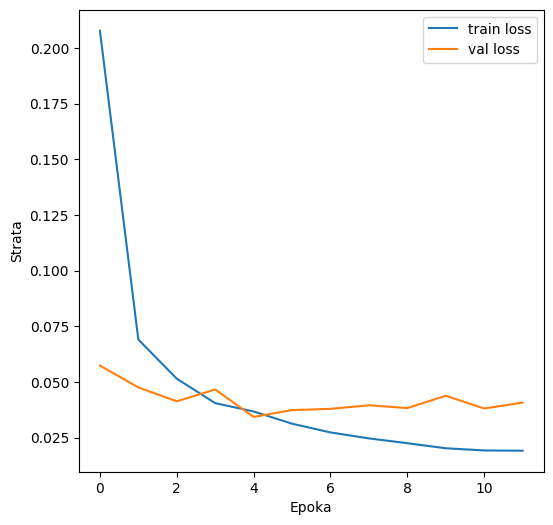

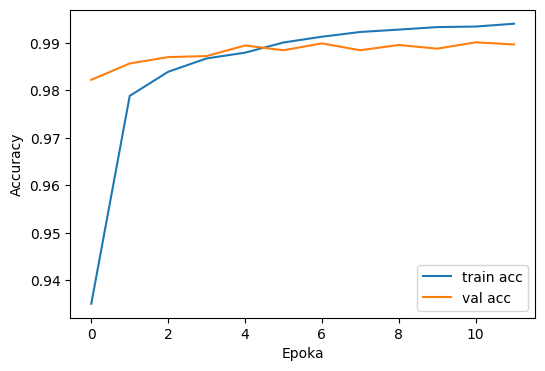

In [109]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"],   label="val loss")
plt.xlabel("Epoka"); plt.ylabel("Strata")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"],   label="val acc")
plt.xlabel("Epoka"); plt.ylabel("Accuracy")
plt.legend(); plt.show()

In [111]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print("Accuracy:", (y_pred == y_true).mean())
print("Macro-F1:", f1_score(y_true, y_pred, average="macro", zero_division=0))
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

Accuracy: 0.9896781354051054
Macro-F1: 0.9896235385601955
              precision    recall  f1-score   support

           0     0.9989    0.9865    0.9926       889
           1     0.9951    0.9951    0.9951      1012
           2     0.9910    0.9888    0.9899       895
           3     0.9978    0.9913    0.9946       921
           4     0.9943    0.9863    0.9903       877
           5     0.9842    0.9963    0.9902       814
           6     0.9822    0.9933    0.9877       889
           7     0.9821    0.9894    0.9857       941
           8     0.9908    0.9852    0.9880       879
           9     0.9799    0.9843    0.9821       893

    accuracy                         0.9897      9010
   macro avg     0.9896    0.9896    0.9896      9010
weighted avg     0.9897    0.9897    0.9897      9010



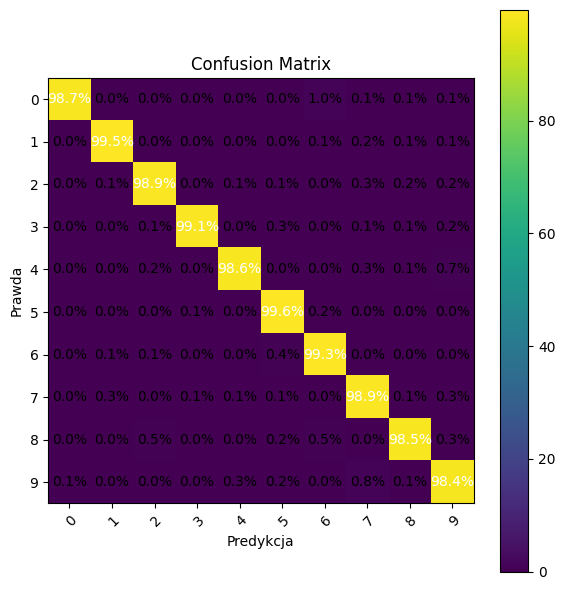

In [112]:
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, class_names=class_names)

In [113]:
print_top_confusions(y_true, y_pred)

Top 10 pomyłek (true → pred, liczność):
0 → 6: 9
9 → 7: 7
4 → 9: 6
6 → 5: 4
8 → 6: 4
8 → 2: 4
2 → 7: 3
3 → 5: 3
4 → 7: 3
7 → 9: 3


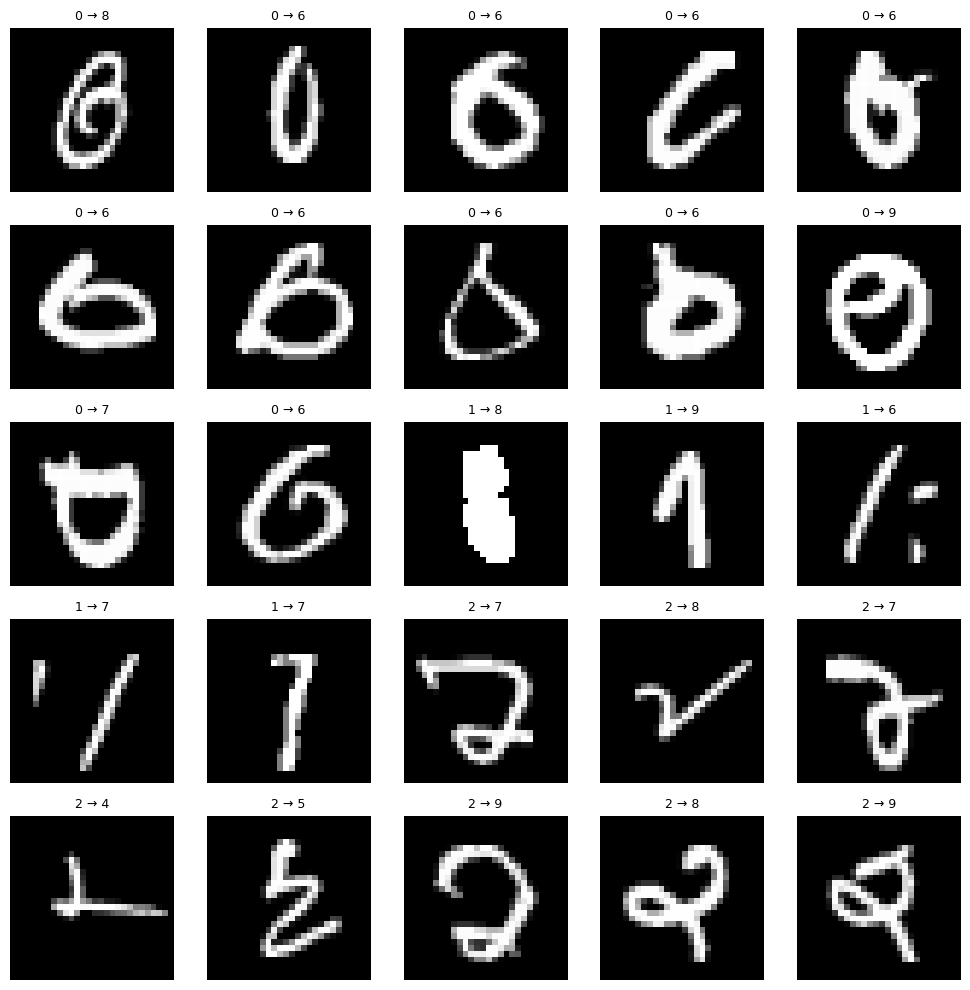

In [114]:
show_misclassified_grid(model, test_loader, DEVICE, max_items=25, class_names=class_names)

#### Wynik modelu zdaje się być znacznie lepszy niż w przypadku prostej sieci neuronowej. Nadal mamy problem z nieodróżnianiem zer od szóstek, ale bądźmy szczerzy - ludziom też zdarzają się takie pomyłki, jeśli zero jest niewyraźnie napisane

### Poeksperymentujmy z innymi wartościami

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(24, 48, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1  = nn.Linear(48 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [117]:
EPOCHS = 12
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")


Ep 01/12 | train loss 0.2544 acc 0.9219 | val loss 0.0722 acc 0.9760
Ep 02/12 | train loss 0.0757 acc 0.9766 | val loss 0.0484 acc 0.9852
Ep 03/12 | train loss 0.0565 acc 0.9825 | val loss 0.0403 acc 0.9881
Ep 04/12 | train loss 0.0471 acc 0.9849 | val loss 0.0442 acc 0.9862
Ep 05/12 | train loss 0.0389 acc 0.9873 | val loss 0.0388 acc 0.9879
Ep 06/12 | train loss 0.0336 acc 0.9894 | val loss 0.0367 acc 0.9895
Ep 07/12 | train loss 0.0317 acc 0.9897 | val loss 0.0339 acc 0.9901
Ep 08/12 | train loss 0.0286 acc 0.9906 | val loss 0.0461 acc 0.9881
Ep 09/12 | train loss 0.0242 acc 0.9919 | val loss 0.0386 acc 0.9894
Ep 10/12 | train loss 0.0241 acc 0.9919 | val loss 0.0390 acc 0.9890
Ep 11/12 | train loss 0.0221 acc 0.9929 | val loss 0.0500 acc 0.9881
Ep 12/12 | train loss 0.0219 acc 0.9923 | val loss 0.0393 acc 0.9900
Czas treningu: 390.0s


In [118]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print("Accuracy:", (y_pred == y_true).mean())
print("Macro-F1:", f1_score(y_true, y_pred, average="macro", zero_division=0))
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

Accuracy: 0.9903440621531632
Macro-F1: 0.9902800060550396
              precision    recall  f1-score   support

           0     0.9966    0.9933    0.9949       889
           1     0.9931    0.9970    0.9951      1012
           2     0.9911    0.9933    0.9922       895
           3     0.9924    0.9913    0.9919       921
           4     0.9943    0.9863    0.9903       877
           5     0.9926    0.9865    0.9895       814
           6     0.9933    0.9933    0.9933       889
           7     0.9883    0.9872    0.9878       941
           8     0.9787    0.9920    0.9853       879
           9     0.9832    0.9821    0.9826       893

    accuracy                         0.9903      9010
   macro avg     0.9903    0.9902    0.9903      9010
weighted avg     0.9904    0.9903    0.9903      9010



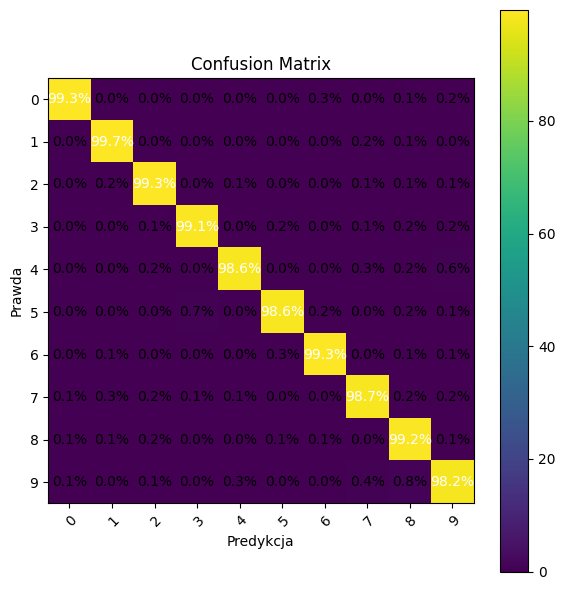

In [119]:
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, class_names=class_names)

In [121]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1  = nn.Linear(96 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [122]:
EPOCHS = 15
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")


Ep 01/15 | train loss 0.2150 acc 0.9330 | val loss 0.0557 acc 0.9830
Ep 02/15 | train loss 0.0733 acc 0.9770 | val loss 0.0485 acc 0.9849
Ep 03/15 | train loss 0.0580 acc 0.9823 | val loss 0.0360 acc 0.9892
Ep 04/15 | train loss 0.0486 acc 0.9846 | val loss 0.0393 acc 0.9877
Ep 05/15 | train loss 0.0410 acc 0.9876 | val loss 0.0388 acc 0.9882
Ep 06/15 | train loss 0.0360 acc 0.9883 | val loss 0.0355 acc 0.9907
Ep 07/15 | train loss 0.0334 acc 0.9900 | val loss 0.0377 acc 0.9898
Ep 08/15 | train loss 0.0298 acc 0.9902 | val loss 0.0379 acc 0.9891
Ep 09/15 | train loss 0.0256 acc 0.9921 | val loss 0.0384 acc 0.9910
Ep 10/15 | train loss 0.0272 acc 0.9908 | val loss 0.0395 acc 0.9899
Ep 11/15 | train loss 0.0236 acc 0.9924 | val loss 0.0322 acc 0.9919
Ep 12/15 | train loss 0.0216 acc 0.9932 | val loss 0.0441 acc 0.9891
Ep 13/15 | train loss 0.0208 acc 0.9933 | val loss 0.0429 acc 0.9908
Ep 14/15 | train loss 0.0179 acc 0.9939 | val loss 0.0392 acc 0.9903
Ep 15/15 | train loss 0.0189 acc 0

In [123]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print("Accuracy:", (y_pred == y_true).mean())
print("Macro-F1:", f1_score(y_true, y_pred, average="macro", zero_division=0))
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

Accuracy: 0.9894561598224195
Macro-F1: 0.9894098448022556
              precision    recall  f1-score   support

           0     0.9944    0.9899    0.9921       889
           1     0.9921    0.9951    0.9936      1012
           2     0.9966    0.9922    0.9944       895
           3     0.9935    0.9902    0.9918       921
           4     0.9886    0.9863    0.9874       877
           5     0.9950    0.9840    0.9895       814
           6     0.9855    0.9966    0.9911       889
           7     0.9904    0.9830    0.9867       941
           8     0.9853    0.9909    0.9881       879
           9     0.9735    0.9854    0.9794       893

    accuracy                         0.9895      9010
   macro avg     0.9895    0.9894    0.9894      9010
weighted avg     0.9895    0.9895    0.9895      9010



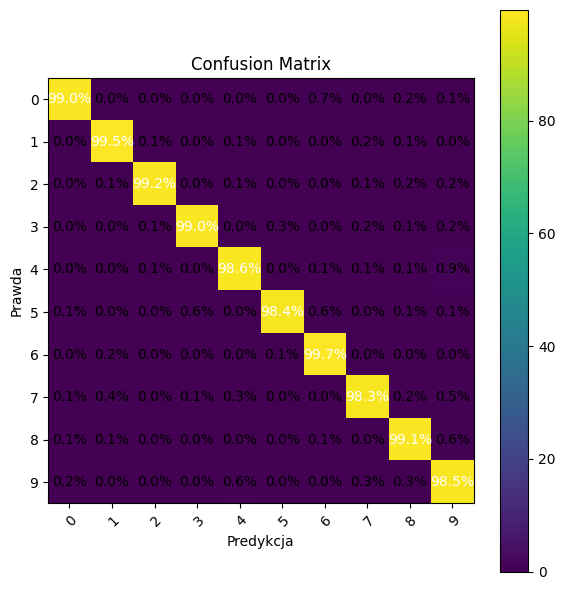

In [124]:
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, class_names=class_names)

#### Poeksperymentuję jeszcze z bardzo skrajnymi wartościami, zdając sobie sprawę, że niosą za sobą duże ryzyko przeuczenia

In [120]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1  = nn.Linear(128 * 7 * 7, 128)
        self.fc2  = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [125]:
EPOCHS = 15
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")


Ep 01/15 | train loss 0.0204 acc 0.9934 | val loss 0.0414 acc 0.9908
Ep 02/15 | train loss 0.0165 acc 0.9949 | val loss 0.0412 acc 0.9912
Ep 03/15 | train loss 0.0163 acc 0.9947 | val loss 0.0387 acc 0.9916
Ep 04/15 | train loss 0.0143 acc 0.9957 | val loss 0.0454 acc 0.9910
Ep 05/15 | train loss 0.0164 acc 0.9947 | val loss 0.0404 acc 0.9919
Ep 06/15 | train loss 0.0152 acc 0.9955 | val loss 0.0394 acc 0.9914
Ep 07/15 | train loss 0.0116 acc 0.9963 | val loss 0.0462 acc 0.9910
Ep 08/15 | train loss 0.0123 acc 0.9959 | val loss 0.0441 acc 0.9912
Ep 09/15 | train loss 0.0130 acc 0.9957 | val loss 0.0485 acc 0.9912
Ep 10/15 | train loss 0.0136 acc 0.9958 | val loss 0.0419 acc 0.9910
Ep 11/15 | train loss 0.0101 acc 0.9968 | val loss 0.0438 acc 0.9918
Ep 12/15 | train loss 0.0115 acc 0.9963 | val loss 0.0621 acc 0.9904
Ep 13/15 | train loss 0.0126 acc 0.9960 | val loss 0.0471 acc 0.9922
Ep 14/15 | train loss 0.0102 acc 0.9968 | val loss 0.0452 acc 0.9920
Ep 15/15 | train loss 0.0123 acc 0

In [126]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print("Accuracy:", (y_pred == y_true).mean())
print("Macro-F1:", f1_score(y_true, y_pred, average="macro", zero_division=0))
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

Accuracy: 0.9910099889012208
Macro-F1: 0.9909674743001821
              precision    recall  f1-score   support

           0     0.9955    0.9955    0.9955       889
           1     0.9931    0.9951    0.9941      1012
           2     0.9966    0.9922    0.9944       895
           3     0.9882    0.9967    0.9924       921
           4     0.9920    0.9897    0.9909       877
           5     0.9975    0.9816    0.9895       814
           6     0.9933    0.9933    0.9933       889
           7     0.9862    0.9883    0.9873       941
           8     0.9809    0.9943    0.9876       879
           9     0.9876    0.9821    0.9848       893

    accuracy                         0.9910      9010
   macro avg     0.9911    0.9909    0.9910      9010
weighted avg     0.9910    0.9910    0.9910      9010



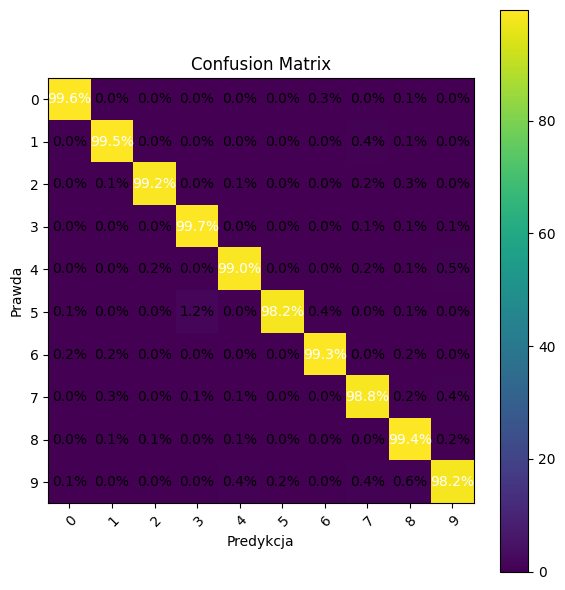

In [127]:
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(cm, class_names=class_names)

In [128]:
print_top_confusions(y_true, y_pred)

Top 10 pomyłek (true → pred, liczność):
5 → 3: 10
9 → 8: 5
1 → 7: 4
4 → 9: 4
7 → 9: 4
9 → 7: 4
9 → 4: 4
0 → 6: 3
2 → 8: 3
5 → 6: 3


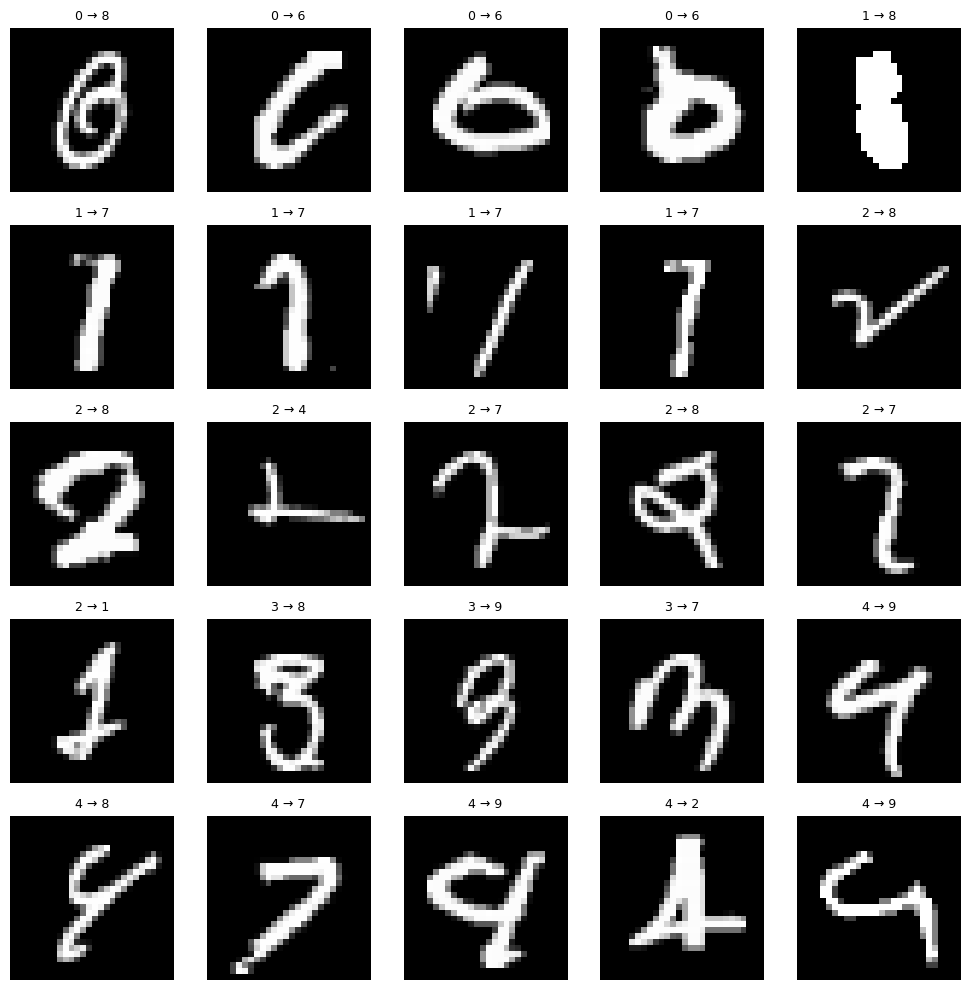

In [129]:
show_misclassified_grid(model, test_loader, DEVICE, max_items=25, class_names=class_names)

## Obserwacje

Co ciekawe, przy zwiększeniu liczby filtrów warstwy konwolucyjnej, model przestał mieć problemy z rozróżnianiem zer od szóstek (choć mogło się to stać w wyniku przeuczenia), natomiast zaczął nieco bardziej mylić piątki z trójkami. Gdy zwizualizowałem liczby, z którymi model miał problem, zauważyłem, że są one też ledwie rozróżnialne dla zwykłego człowieka i pomiędzy sporą częścią z nich sam bym się wahał, jaka liczba jest przedstawiona.

## Wnioski

Zwiększenie filtrów warst sieci konwolucyjnej może prowadzić do przeuczenia modelu, równocześnie oczywiście poprawiając jego predykcje na danych testowych. Bliskie optymalnych zdają się być te wartości:
```
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)
```
Gdyż ani nie dopasowują się nadmiernie do danych, ani nie odbiegają jakością predykcji od modelów bardziej podatnych na overfitting. Większość nierozpoznanych przez sieć liczb jest również, subiektywnie, trudnie rozpoznawalna dla człowieka, co świadczy o dobrej jakości wskzaniach modelu. Użycie entropii krzyżowej jako walidacji sieci okazało się bardzo skuteczne przy problemie zakładającym istnienie wielu klas. Zwiększenie liczby epok istotnie zwiększało czas treningu, jednocześnie niezbyt istotnie poprawiając czas predykcji. Zdaje się, że liczba od 12 do 15 epok dla zadanego algorytmu optymalizacyjnego jest najlepszym wyborem dla maksymalizacji stosunku jakości predykcji do czasu uczenia.

In [130]:
save_path = "mnist_cnn.pt"
torch.save(model.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

Model zapisany do: c:\Users\jakub\Downloads\ML - wakacyjne wyzwanie - część 3\mnist_cnn.pt
